In [1]:
#!/usr/bin/env python3
"""
Visualization script for k-shot accuracy analysis from elix_results.
Analyzes llama-3.1-8b-instruct across multiple seeds without persona separation.
"""

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import json
import glob
from collections import defaultdict
import os

# Set the style for beautiful plots
plt.style.use('seaborn-v0_8-darkgrid')

# Configure matplotlib for better aesthetics
plt.rcParams['figure.figsize'] = (14, 8)
plt.rcParams['font.size'] = 12
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['xtick.labelsize'] = 11
plt.rcParams['ytick.labelsize'] = 11
plt.rcParams['legend.fontsize'] = 12
plt.rcParams['figure.titlesize'] = 18

In [3]:
# Define the model and path
model_name = 'llama-3.1-8b-instruct'
results_folder = f'elix_results/{model_name}/'

def load_elix_data(results_folder):
    """
    Load data from elix_results.
    Returns: data_dict[seed][k_shot] = accuracy
    """
    # Load all metadata JSON files with level_filtered pattern
    metadata_files = glob.glob(os.path.join(results_folder, 'metadata_seed_*_k*_level_filtered.json'))
    
    # Organize data: data_dict[seed][k_shot] = accuracy
    data_dict = defaultdict(dict)
    all_seeds = set()
    all_k_shots = set()
    
    # Parse all JSON files
    for filepath in metadata_files:
        with open(filepath, 'r') as f:
            data = json.load(f)
        
        seed = data['seed']
        k_shot = data['k_shot']
        accuracy = data['accuracy_metrics']['accuracy'] * 100  # Convert to percentage
        
        data_dict[seed][k_shot] = accuracy
        all_seeds.add(seed)
        all_k_shots.add(k_shot)
    
    return data_dict, sorted(all_seeds), sorted(all_k_shots)

# Load the data
print(f"Loading data from {results_folder}...")
data_dict, all_seeds, all_k_shots = load_elix_data(results_folder)

print(f"Found {len(all_seeds)} seeds: {all_seeds}")
print(f"Found {len(all_k_shots)} k-shot values: {all_k_shots}")
print()

Loading data from elix_results/llama-3.1-8b-instruct/...
Found 5 seeds: [42, 123, 999, 3407, 114514]
Found 6 k-shot values: [0, 1, 2, 3, 4, 8]



In [4]:
# Organize data into matrix: shape (num_seeds, num_k_shots)
accuracy_matrix = []

for seed in all_seeds:
    seed_accuracies = []
    for k_shot in all_k_shots:
        acc = data_dict[seed].get(k_shot, np.nan)
        seed_accuracies.append(acc)
    accuracy_matrix.append(seed_accuracies)

accuracy_matrix = np.array(accuracy_matrix)

# Calculate mean and std across seeds (axis=0)
mean_accuracy = np.nanmean(accuracy_matrix, axis=0)
std_accuracy = np.nanstd(accuracy_matrix, axis=0)

# Count valid data points for each k-shot
valid_counts = np.sum(~np.isnan(accuracy_matrix), axis=0)

# Print statistics
print("Statistics:")
print("=" * 60)
for i, k in enumerate(all_k_shots):
    if not np.isnan(mean_accuracy[i]):
        print(f"K-shot {k}: Mean = {mean_accuracy[i]:.2f}%, Std = {std_accuracy[i]:.2f}%, n = {int(valid_counts[i])}")
    else:
        print(f"K-shot {k}: No data available")
print()

Statistics:
K-shot 0: Mean = 83.98%, Std = 0.00%, n = 5
K-shot 1: Mean = 83.32%, Std = 1.16%, n = 5
K-shot 2: Mean = 84.14%, Std = 1.15%, n = 5
K-shot 3: Mean = 83.95%, Std = 0.45%, n = 5
K-shot 4: Mean = 84.18%, Std = 0.52%, n = 5
K-shot 8: Mean = 84.30%, Std = 0.50%, n = 5



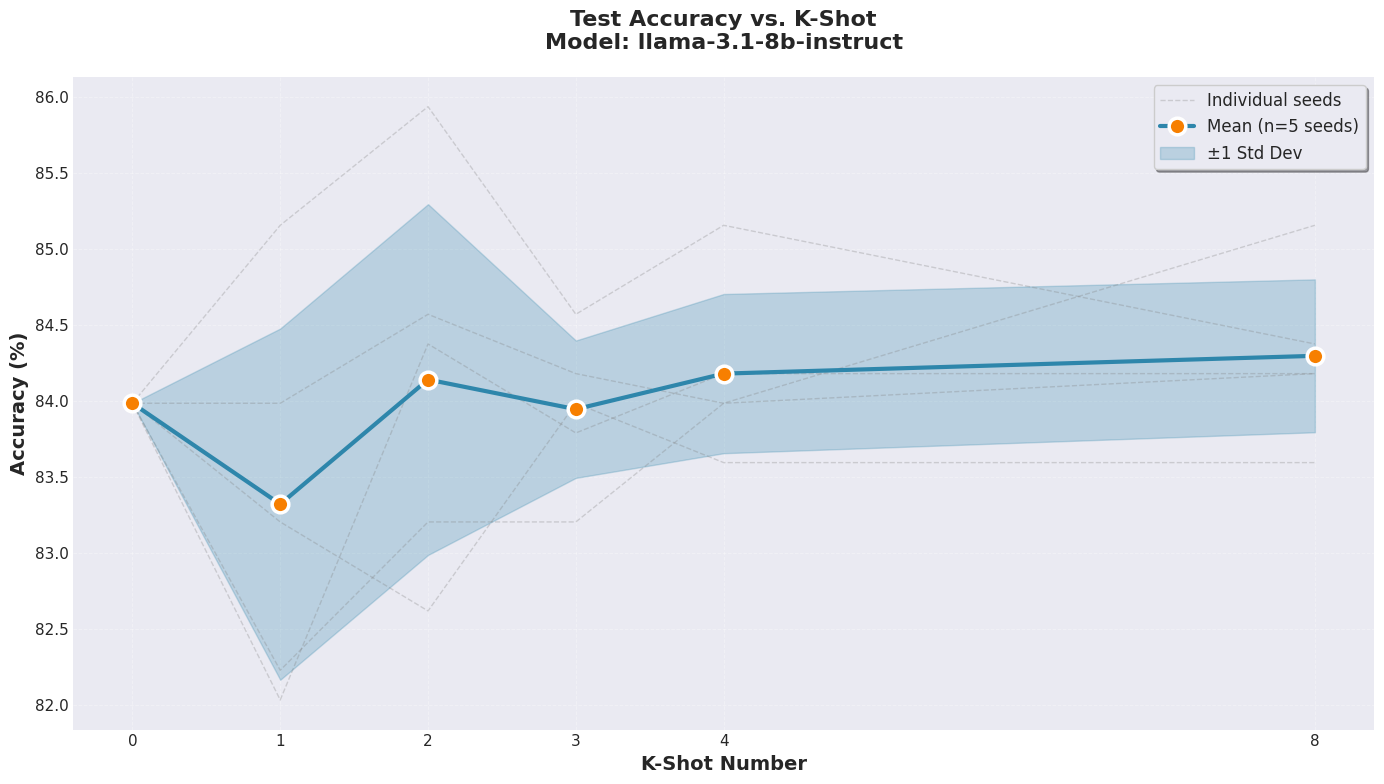

In [5]:
# Create the main plot
fig, ax = plt.subplots(figsize=(14, 8))

# Plot individual seeds as light lines
for seed_idx, seed in enumerate(all_seeds):
    ax.plot(all_k_shots, accuracy_matrix[seed_idx], 
            linestyle='--', linewidth=1, alpha=0.3, color='gray',
            label='Individual seeds' if seed_idx == 0 else '')

# Plot mean with markers
ax.plot(all_k_shots, mean_accuracy, marker='o', linewidth=3, markersize=12,
        color='#2E86AB', markerfacecolor='#F77F00', 
        markeredgewidth=2.5, markeredgecolor='white', 
        label=f"Mean (n={len(all_seeds)} seeds)", zorder=3)

# Add shaded region for ±1 standard deviation
ax.fill_between(all_k_shots, 
                mean_accuracy - std_accuracy, 
                mean_accuracy + std_accuracy,
                alpha=0.25, color='#2E86AB', 
                label='±1 Std Dev', zorder=1)

# Customize the plot
ax.set_xlabel('K-Shot Number', fontweight='bold', fontsize=14)
ax.set_ylabel('Accuracy (%)', fontweight='bold', fontsize=14)
ax.set_title(f'Test Accuracy vs. K-Shot\nModel: {model_name}', 
             fontweight='bold', fontsize=16, pad=20)

# Add grid for better readability
ax.grid(True, alpha=0.3, linestyle='--', linewidth=0.7)
ax.set_axisbelow(True)

# Customize ticks
ax.set_xticks(all_k_shots)
ax.set_xticklabels([str(k) for k in all_k_shots])

# Set y-axis limits (optional - uncomment to fix range)
# ax.set_ylim(0, 100)

# Add legend
ax.legend(loc='best', frameon=True, shadow=True, fancybox=True)

# Tight layout for better spacing
plt.tight_layout()

# Display the plot
plt.show()

In [ ]:
# Save the figure
output_path = f'elix_kshot_accuracy_{model_name}.png'
fig.savefig(output_path, dpi=300, bbox_inches='tight', facecolor='white')
print(f"Figure saved to: {output_path}")

# Save as PDF as well
output_path_pdf = f'elix_kshot_accuracy_{model_name}.pdf'
fig.savefig(output_path_pdf, bbox_inches='tight', facecolor='white')
print(f"Figure saved to: {output_path_pdf}")

print("\n" + "="*60)
print("Visualization complete!")
print("="*60)

In [ ]:
# Optional: Create a detailed table view
import pandas as pd

# Create a DataFrame for easier viewing
df_data = {'k_shot': all_k_shots}
for seed in all_seeds:
    df_data[f'seed_{seed}'] = [data_dict[seed].get(k, np.nan) for k in all_k_shots]

df_data['mean'] = mean_accuracy
df_data['std'] = std_accuracy

df = pd.DataFrame(df_data)
print("\nDetailed accuracy table:")
print(df.to_string(index=False))